In [1]:
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
import numpy
import matplotlib.patches as patches
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from PDE2D.Coefficient import *
from PDE2D.utils import *
from PDE2D.BoundaryShape import *
from PDE2D.Solver import *
from PDE2D import GreenSampling, Split
import matplotlib.patches as patches

In [2]:
conf_numbers = [UInt32(0), UInt32(1)]
conf_vis = 1

In [3]:
green = GreenSampling.Polynomial
split = Split.Naive
bbox = [[-1.05, -1.05], [1.05, 1.05]]
resolution_image = [256, 256]
spp_image = 512
epsilon = 1e-5

res = 256
spp_boundary = 2 ** 20

radius = 1
computation_radius = 0.8

parameters = {}
parameters["freq"] = 2
parameters["bias"] = 6
parameters["scale"] = 1

def boundary_dirichlet(points, parameters):
    angle = dr.atan2(points[0], points[1])
    return parameters["scale"] * dr.sin(angle * parameters["freq"]) + parameters["bias"]

out_dirichlet = ConstantCoefficient("dirichlet", 3)
out_neumann1 = ConstantCoefficient("neumann", 5)
out_neumann2 = ConstantCoefficient("neumann", -5)

out_boundary = CircleShape(origin =Point2f(0.0, 0.0), radius = 1.0, name = "out-boundary", 
                        dirichlet=[out_dirichlet], neumann = [out_neumann1], epsilon = epsilon, 
                        angle_partition = [0, np.pi/2], dirichlet_map = [False, True])
    

object_potential1 = -10
origin_object1 =Point2f(0.1, 0.2)
radius_object1 = Float(0.3)
dirichlet1 = [0., -12.]
in_boundary1 = CircleShape(origin = origin_object1, radius = radius_object1, 
                          name = 'in-boundary1', epsilon = epsilon)

object_potential2 = 10
origin_object2 =Point2f(-.4, -.4)
radius_object2 = Float(0.1)
dirichlet2 = [0., 12]
in_boundary2 = CircleShape(origin = origin_object2, radius = radius_object2, 
                          name = 'in-boundary2', epsilon = epsilon)

in_boundaries = [in_boundary1, in_boundary2]
#in_boundaries = [in_boundary1]

shape = BoundaryWithDirichlets(out_boundary, in_boundaries, dirichlet_values= [dirichlet1, dirichlet2])
σ = ConstantCoefficient("screening", 10)
data_holder = DataHolder(shape, σ = σ)

In [4]:
points = create_image_points(bbox, resolution_image, spp_image)
wos = WostConstant(data_holder, green_sampling= green)
L, p = wos.solve(points_in = points, conf_numbers=conf_numbers)
image_0, tensor = create_image_from_result(L, resolution_image)


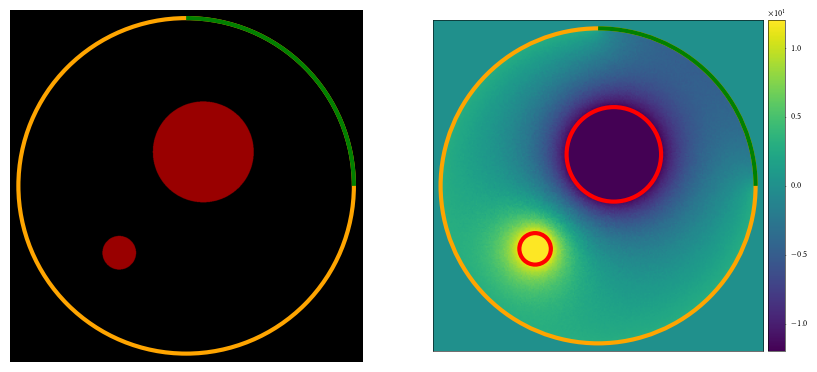

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (10, 5))
shape.sketch_image(ax1, bbox, [1024, 1024])
plot_image(image_0[conf_vis], ax2)
shape.sketch(ax2, bbox, resolution_image, fill = False)

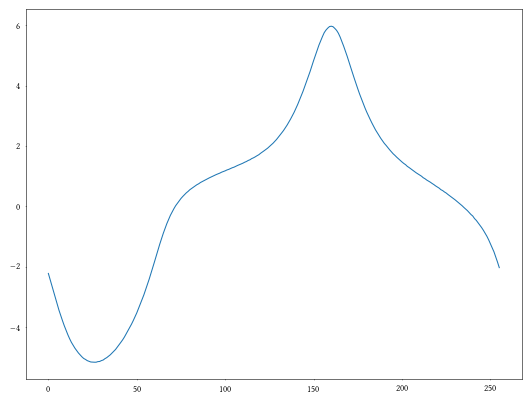

In [6]:

points, _, normal_dir = shape.out_boundary.create_boundary_points(distance=radius - computation_radius, res = res, spp = spp_boundary)
L, _ = wos.solve(points_in = points, conf_numbers= conf_numbers)
tensor, tensor_mi = shape.out_boundary.create_boundary_result(L, resolution = res)
boundary_dirichlet = shape.out_boundary.create_boundary_coefficient(tensor_mi)
plt.plot(tensor[conf_vis])


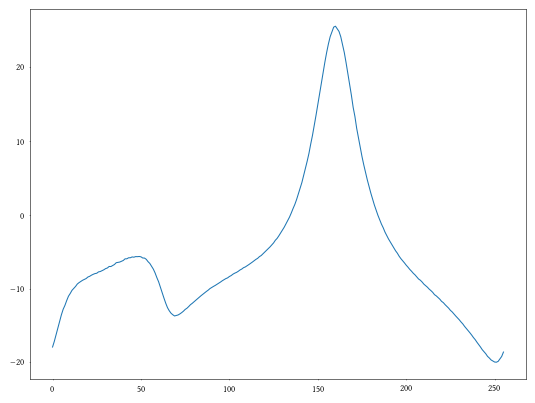

In [7]:
L_der, _ = wos.solve(points_in = points, derivative_dir = -dr.normalize(points), conf_numbers = conf_numbers)
tensor_der, tensor_mi_der = shape.out_boundary.create_boundary_result(L_der, resolution = res)
boundary_neumann= shape.out_boundary.create_boundary_coefficient(tensor_mi_der)
plt.plot(tensor_der[conf_vis])

Text(0.5, 1.0, 'Dirichlet Cut')

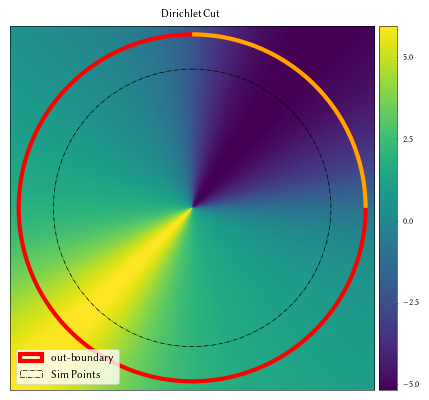

In [8]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
ress = [4096, 4096]
d = boundary_dirichlet[conf_vis].visualize(ax, bbox, resolution= ress)
shape.out_boundary.sketch(ax, bbox, ress)
ax.legend(loc="lower left", fontsize=8)
rplot =  computation_radius * ress[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([ress[0]/2 - 0.5, ress[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc = "lower left", fontsize = 8)
ax.set_title("Dirichlet Cut")

Text(0.5, 1.0, 'Neumann Cut')

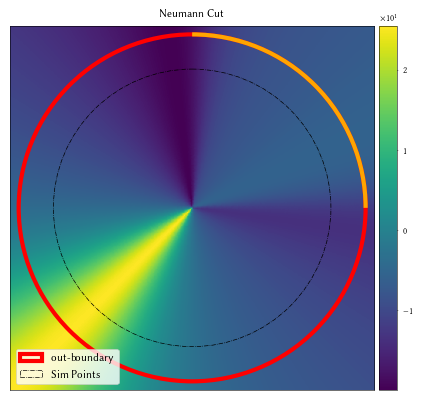

In [9]:
fig, (ax) = plt.subplots(1, 1, figsize=[5, 5])
a = boundary_neumann[conf_vis].visualize(ax, bbox, resolution= resolution_image)
shape.out_boundary.sketch(ax, bbox, resolution_image)
rplot =  computation_radius * resolution_image[0] / (bbox[1][1] - bbox[0][1])
sphere = patches.Ellipse([resolution_image[0]/2 - 0.5, resolution_image[0]/2 -0.5], 
                         rplot * 2, rplot * 2, 
                         fill = False, color = "black", label = "Sim Points", ls="-.")
ax.add_patch(sphere)
ax.legend(loc="lower left", fontsize=8)
ax.set_title("Neumann Cut")

In [10]:
angle_partition1 = np.array([0, 2 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map1 = np.array([False, False, False, True])
angle_partition2 = np.array([0, 3 * np.pi/4, np.pi, 7 * np.pi / 4])
dirichlet_map2 = np.array([True, False, True, False])
out_shape1 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon, dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition1, dirichlet_map=dirichlet_map1)
shape1 = BoundaryWithDirichlets(out_boundary=out_shape1, dirichlet_boundaries = in_boundaries, dirichlet_values = [dirichlet1, dirichlet2])

out_shape2 = CircleShape(origin=Point2f(0., 0.), radius=computation_radius, epsilon= epsilon,dirichlet=boundary_dirichlet, neumann = boundary_neumann,
                     angle_partition=angle_partition2, dirichlet_map=dirichlet_map2)
shape2 = BoundaryWithDirichlets(out_boundary=out_shape2, dirichlet_boundaries = in_boundaries, dirichlet_values= [dirichlet1, dirichlet2])
data_holder1 = DataHolder(shape1, σ = σ)
data_holder2 = DataHolder(shape2, σ = σ)

In [11]:
bbox_ = [[-1.05 * computation_radius, -1.05 * computation_radius], [1.05 * computation_radius, 1.05 * computation_radius]]
points = create_image_points(bbox_, resolution_image, spp_image)
wos1 = WostConstant(data_holder1, green_sampling = green)
L1, _ = wos1.solve(points_in = points, conf_numbers = conf_numbers)
image1, tensor = create_image_from_result(L1, resolution_image)
wos2 = WostConstant(data_holder2, green_sampling = green)
L2, _ = wos2.solve(points_in = points, conf_numbers = conf_numbers)
image2, tensor = create_image_from_result(L2, resolution_image)

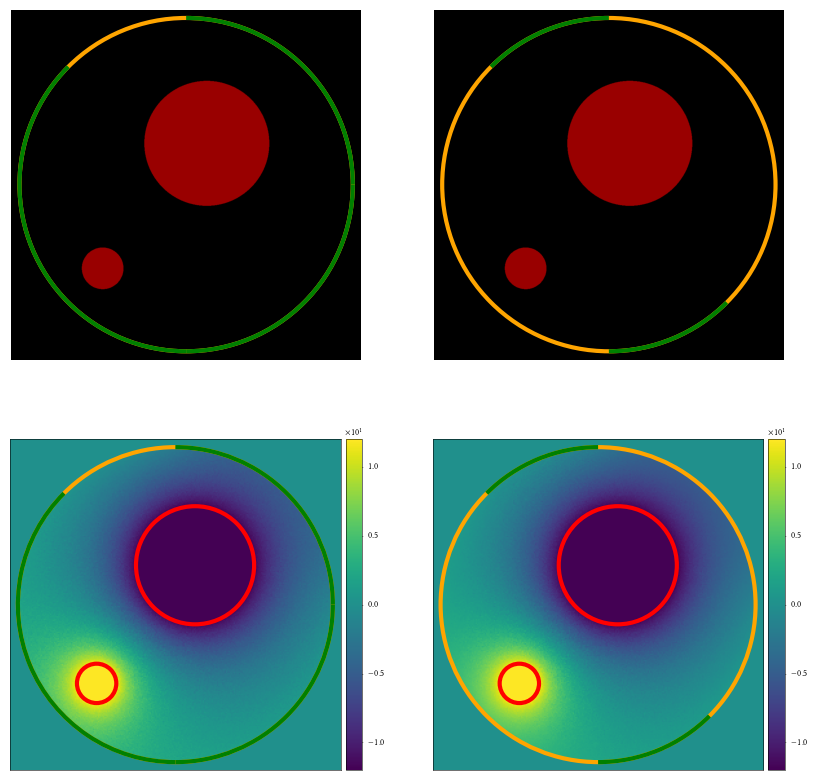

In [12]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 10])
max_val = max(image1[conf_vis].max(), image2[conf_vis].max())
min_val = min(image1[conf_vis].min(), image2[conf_vis].min())
range_ = [min_val, max_val]
#range_ = [0, 1]
shape1.sketch_image(ax1, bbox_, [1024, 1024])
shape2.sketch_image(ax2, bbox_, [1024, 1024])
plot_image(image1[conf_vis], ax3, input_range=range_)
plot_image(image2[conf_vis], ax4, input_range=range_)
shape1.sketch(ax3, bbox_, resolution_image, fill = False)
shape2.sketch(ax4, bbox_, resolution_image, fill = False)


Mean:
0.0010803903
Variance:
0.015673084


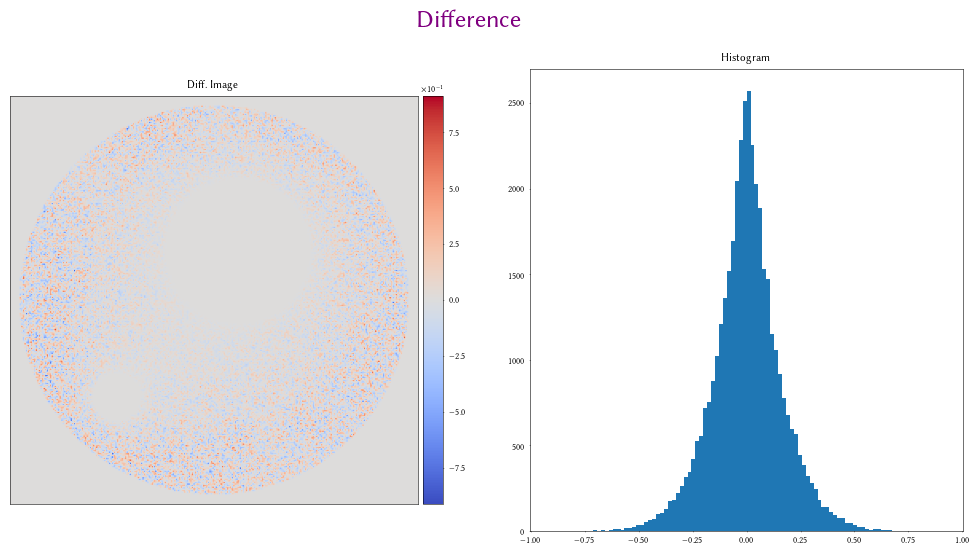

In [13]:
sketch_diff(image1[conf_vis], image2[conf_vis], max_range = 10000)